In [2]:
%%capture output
%run "3. Feature Engineering, Extraction and Selection.ipynb"
print('Operation complete')

# Model Selection and Evaluation

## Importing dependencies

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier

#models
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Modeling

### Model Selection

After creating the classification model objects, I will proceed by performing a k=10 cross-validation

In [4]:
# creating the objects
NB = GaussianNB()
MNB = MultinomialNB()
LR = LogisticRegression(random_state=1)
SV = SVC()
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
XGB = xgb.XGBClassifier()
KNN = KNeighborsClassifier()
# model.get_params()

### Which model should i pick?

To have a really general idea on our models let's run our models firstly on all the data, then on the train and test sets respectively.

In [5]:
X = tfidf.fit_transform(data['Clean Review']).toarray()
y = data['Target']

crossval_dict = {0: 'Naive Bayes', 
                1: 'Multinomial Naive Bayes',
                2: 'Logistic Regression',
                3: 'SVC',
                4: 'Decision Tree',
                5: 'Random Forest',
                6: 'XGBoost',
                7: 'KNN'}
crossval_models=[NB, MNB, LR, SV, DT, RF, XGB, KNN]

# iterate over all the models computing the general accuracy on all the data
for i, model in enumerate(crossval_models):
    print("{} Trial Accuracy: {}".format(crossval_dict[i], cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Naive Bayes Trial Accuracy: 0.8432432432432432
Multinomial Naive Bayes Trial Accuracy: 0.8689189189189189
Logistic Regression Trial Accuracy: 0.8783783783783784
SVC Trial Accuracy: 0.8770270270270271
Decision Tree Trial Accuracy: 0.8405405405405405
Random Forest Trial Accuracy: 0.8810810810810811
XGBoost Trial Accuracy: 0.8878378378378378
KNN Trial Accuracy: 0.8878378378378379


Cross_val_score is a function from scikit-learn that outputs the average accuracy by performing cross-validation: it splits the data into multiple folds and evaluates the model's performance on each fold, in this case 10 folds. 

Now looking at the results, we notice that all the accuracies are between 80% and 90%. Therefore it is necessary to compare the models from different points of view. Let's take a look at more specific metrics for classification tasks such as precision and F1 for each non optimized model.

In [6]:
print('------------------TRAIN SET------------------')
results = []
for i, model in enumerate(crossval_models):
    # train the models
    model.fit(X_train, y_train)

    # compute metrics and append them to the results list
    accuracy = model.score(X_train, y_train)
    precision = precision_score(y_train, model.predict(X_train), average="micro")
    # micro avg is preferable if there is class imbalance
    # micro-average aggregates the contributions of all classes
    f1 = f1_score(y_train, model.predict(X_train), average="weighted")
    results.append({'Model': crossval_dict[i], 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

df_results = pd.DataFrame(results)
df_results

------------------TRAIN SET------------------


,Model,Accuracy,Precision,F1
0,Naive Bayes,0.993363,0.993363,0.993351
1,Multinomial Naive Bayes,0.988201,0.988201,0.988149
2,Logistic Regression,1.000000,1.000000,1.000000
3,SVC,1.000000,1.000000,1.000000
4,Decision Tree,1.000000,1.000000,1.000000
5,Random Forest,1.000000,1.000000,1.000000
6,XGBoost,1.000000,1.000000,1.000000
7,KNN,0.776549,0.776549,0.736799


The F1 suggests that the KNN, which was the best in the previous output, is now the worst model. Seems like the models are overfitting the training data. To show an example of overfitting in this case we will use the decision tree, which is simple to visualize.

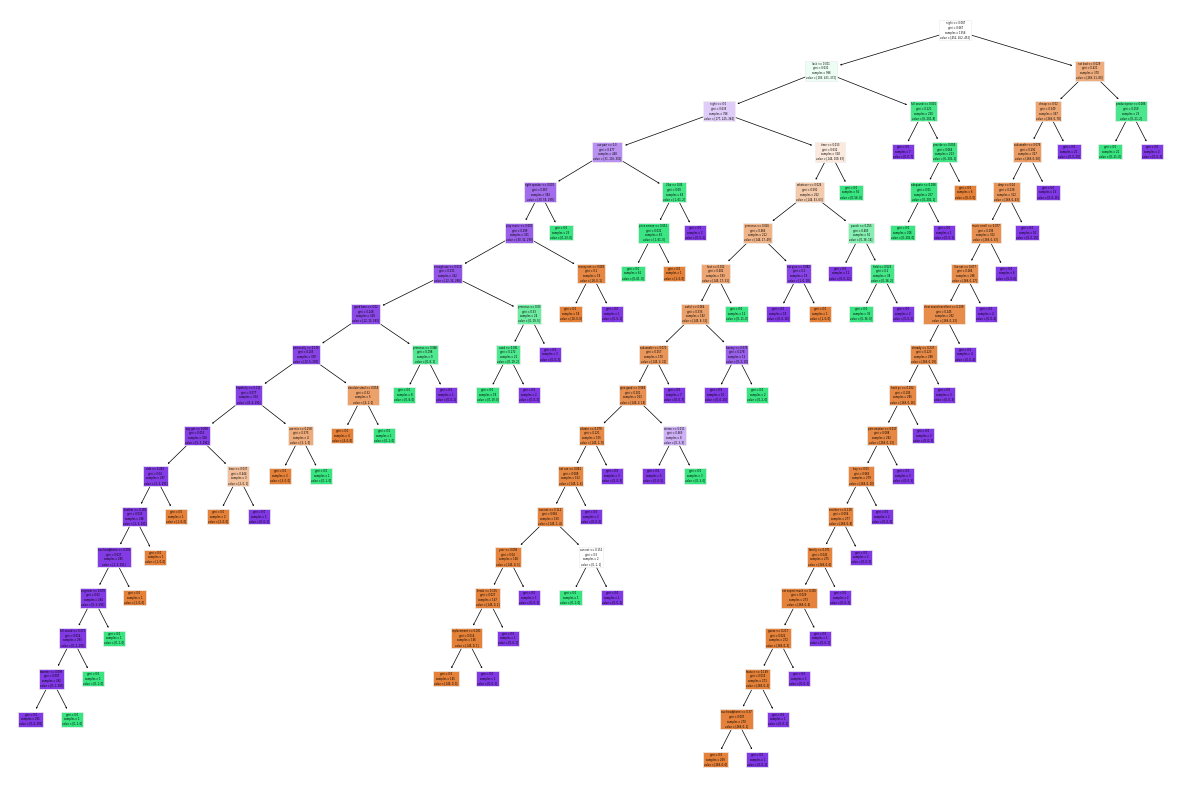

In [7]:
DT.fit(X_train, y_train)
plt.figure(figsize=(15,10))
plot_tree(decision_tree=DT, feature_names=tfidf.get_feature_names(), filled=True)
plt.show()

In the leaves we probably have just single observations/reviews. We need a much more generalized tree.

#### Cross-Validation

I will now try to mitigate the overfitting problem with cross-validation. I will create two plots side by side, one for accuracy and one for the F1 score. Each subplot will display the bar plots for the respective scores on the train set across different folds. The red dashed line represents the average score for each metric. This arrangement allows for easy comparison between accuracy and F1 scores in the k-fold validation.

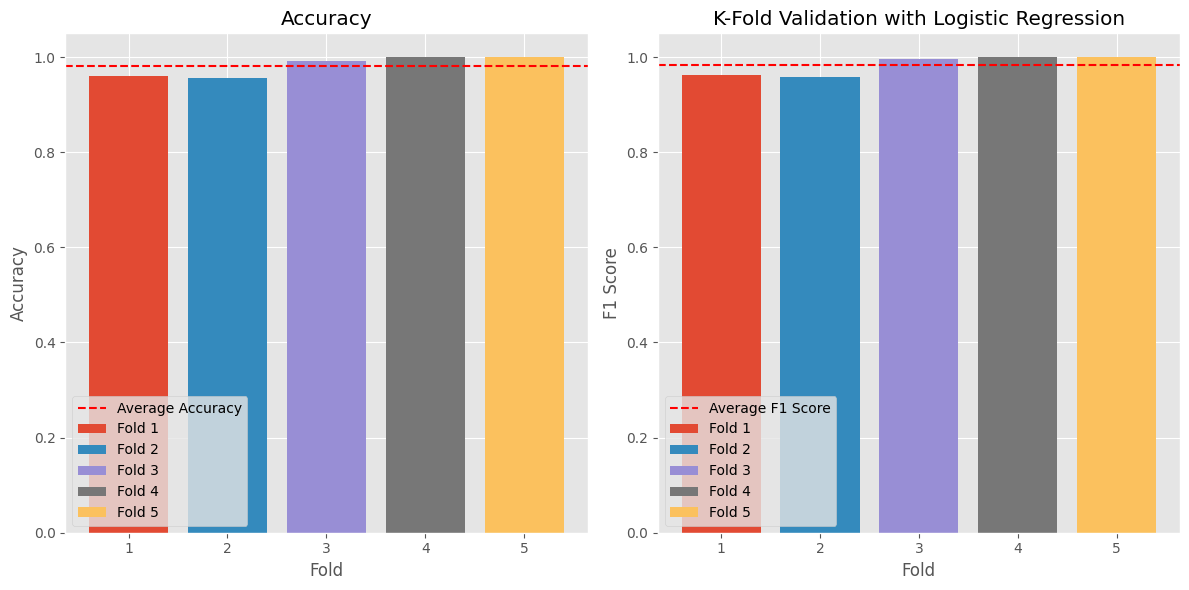

In [8]:
scores_acc = []
scores_f1 = []
cv = KFold(n_splits=5)          # 5 subgroups
i = 1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for train, test in cv.split(X_train, y_train):
    prediction = LR.fit(X_train[train], y_train[train]).predict(X_train[test])
    true = y_train[test]
    # Accuracy
    score_acc = accuracy_score(true, prediction)
    scores_acc.append(score_acc)
    axes[0].bar(i, score_acc, label='Fold %d' % i)
    # F1
    score_f1 = f1_score(true, prediction, average='weighted')
    scores_f1.append(score_f1)
    axes[1].bar(i, score_f1, label='Fold %d' % i)
    i += 1

# Average Accuracy
axes[0].axhline(y=np.mean(scores_acc), color='r', linestyle='--', label='Average Accuracy')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()

# Average F1 Score
axes[1].axhline(y=np.mean(scores_f1), color='r', linestyle='--', label='Average F1 Score')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score')
axes[1].legend()

plt.title('K-Fold Validation with Logistic Regression')
plt.tight_layout()
plt.show()

What I have done now is a strange thing, but I just really wanted to try the models. Overall Pretty good results I would say, with the "False Positive" reviews classified as positive as expected from lookin at the analysis as a whole. Obviously, not as great as on the validation set but we need to remember that we are dealing with **different and less** reviews.

### Hyperparameter tuning

#### Functions

Let's apply different random configurations to see how to model's accuracy changes in train and test sets. We need to pay attention to how the accuracies are similar when we reduce the model's complexity. We should pick up a good configuration based on the test accuracy.

For the hyperparameter tuning there are different approaches, but in this analysis I will use the Grid Search Optimization: it creates a grid-like structure with all possible combinations of the predefined set of hyperparameters and evaluates each combination using **cross-validation** (or a separate validation set), which will help to reduce the overfitting. Since in some case it takes too much time, I will implement a Randomized Search which works in the same way as the Grid Search but only on a random subset of the combinations.

We will do hyperparameter optimization on:
- Logistic Regression
- Random Forest
- SVC
- XGBoost

In [9]:
# defining a hyperparameter tuning function
def hypertuning(classifier, param_grid, metric='accuracy', verbose_value=1):
    cv_method = KFold(n_splits=5, shuffle=True)     # creating a 5 cross-k-validation method
    model = RandomizedSearchCV(
            estimator = classifier,
            param_distributions = param_grid,
            n_iter = 10,
            scoring = metric,
            n_jobs = -1, 
            cv = cv_method, 
            verbose = verbose_value, 
            random_state = 1)
    
    # then fit the new model and get the best model
    model.fit(X_train, y_train)

    # create the new fine tuned model
    best_model = model.best_estimator_

    # best score
    print(f"Best Score: {model.best_score_}")       # best_score_ is the average of all cv folds for a single combination of the parameters
    
    # hyperparams found
    print("Hyperparameter set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):        # for loop to have them printed nicely
        print(f"\t{param_name}: {best_parameters[param_name]}")
    
    # accuracy
    y_pred = best_model.predict(X_test)
    print(f'Tuned LR accuracy on test set is: {accuracy_score(y_test, y_pred)}')
    print(f'Tuned LR F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

    # confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(confusion, classes=['Negative','Neutral','Positive'])
    return best_model

In [10]:
# defining a function to plot the 3x3 confusion matrix
def confusion_matrix_plot(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Tuning MNBayes Classifier

In [53]:
MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)
print(f'Base MNB accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base MNB F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base MNB accuracy on test set is: 0.8288288288288288
Base MNB F1 score on test set is: 0.8451086991822392


In [57]:
mnb_params = {
    'alpha': [0.1, 0.5, 1.0],   # Example values for alpha
    'fit_prior': [True, False],  # Example values for fit_prior
    'class_prior': [None, [0.2, 0.8], [0.5, 0.5]]   # Example values for class_prior
}


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.9889353158237464
Hyperparameter set:
	alpha: 0.1
	class_prior: None
	fit_prior: False
Tuned LR accuracy on test set is: 0.8828828828828829
Tuned LR F1 score on test set is: 0.8748786816104331


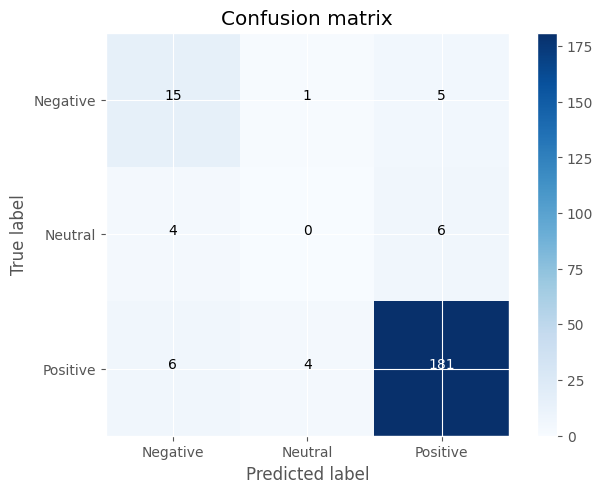

In [58]:
best_MNB = hypertuning(classifier = MNB, 
                      param_grid = mnb_params, 
                      metric='accuracy', 
                      verbose_value=1)

#### Tuning Logistic Regression

In [11]:
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print(f'Base LR accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base LR F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base LR accuracy on test set is: 0.9054054054054054
Base LR F1 score on test set is: 0.8866723610909658


In [12]:
# defining hyperparameter space
# definign the most parameters since this will problably be our final model
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'C': np.arange(0, 1, 0.01),
    'fit_intercept': [True, False],
    'intercept_scaling': [1, 10, 100],
    'class_weight': [None, 'balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': range(100, 500),
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'warm_start': [True, False],
    'n_jobs': [None, 1, -1]
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.9955828087692643
Hyperparameter set:
	C: 0.6
	class_weight: balanced
	dual: False
	fit_intercept: True
	intercept_scaling: 10
	max_iter: 121
	multi_class: multinomial
	n_jobs: -1
	penalty: none
	solver: saga
	tol: 0.01
	warm_start: False
Tuned LR accuracy on test set is: 0.9009009009009009
Tuned LR F1 score on test set is: 0.8806160565742446


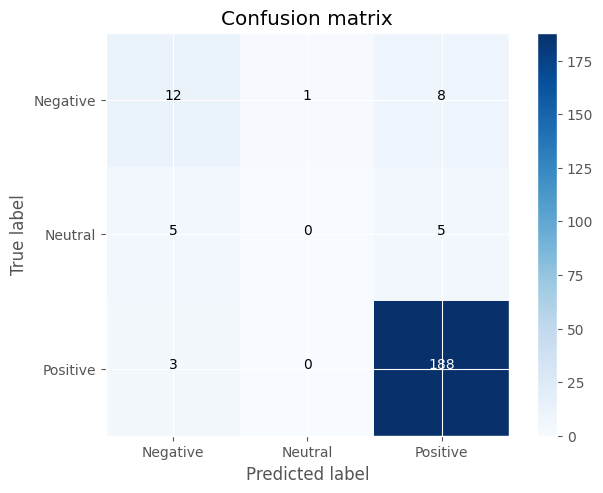

In [13]:
best_LR = hypertuning(classifier = LR, 
                      param_grid = lr_params, 
                      metric='accuracy', 
                      verbose_value=1)

#### Tuning Random Forest

In [14]:
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print(f'Base RF accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base RF F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base RF accuracy on test set is: 0.8783783783783784
Base RF F1 score on test set is: 0.8428284720363929


In [15]:
# define the hyperparameter space
rf_params = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 8],    # Minimum number of samples required to be at a leaf node
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'n_estimators': [100, 200, 400],
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.9874593010635989
Hyperparameter set:
	bootstrap: True
	max_depth: 25
	min_samples_leaf: 1
	min_samples_split: 2
	n_estimators: 400
Tuned LR accuracy on test set is: 0.8693693693693694
Tuned LR F1 score on test set is: 0.8290980635808223


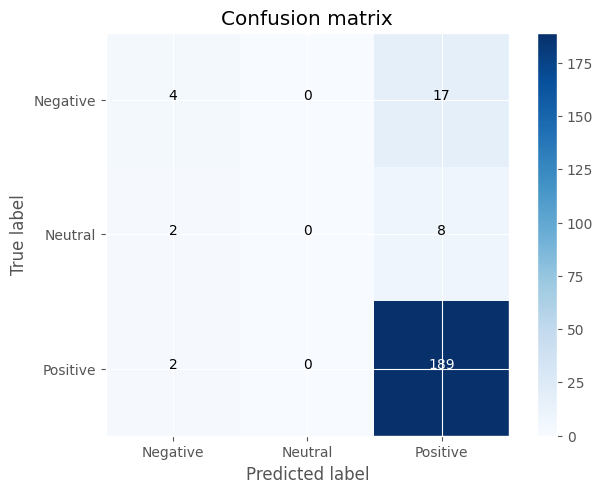

In [16]:
best_RF = hypertuning(classifier = RF, 
                      param_grid = rf_params, 
                      metric='accuracy', 
                      verbose_value=1)

#### Tuning Support Vector Machine Classifier

In [17]:
SV.fit(X_train, y_train)
y_pred = SV.predict(X_test)
print(f'Base SVC accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base SVC F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base SVC accuracy on test set is: 0.8738738738738738
Base SVC F1 score on test set is: 0.8252526917161064


In [18]:
# define the hyperparameter space
svc_params = {
    'C': [0.1, 1, 10],  # error term parameter
    'kernel': ['linear', 'rbf']
}

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score: 1.0
Hyperparameter set:
	C: 10
	kernel: rbf
Tuned LR accuracy on test set is: 0.8738738738738738
Tuned LR F1 score on test set is: 0.8252526917161064


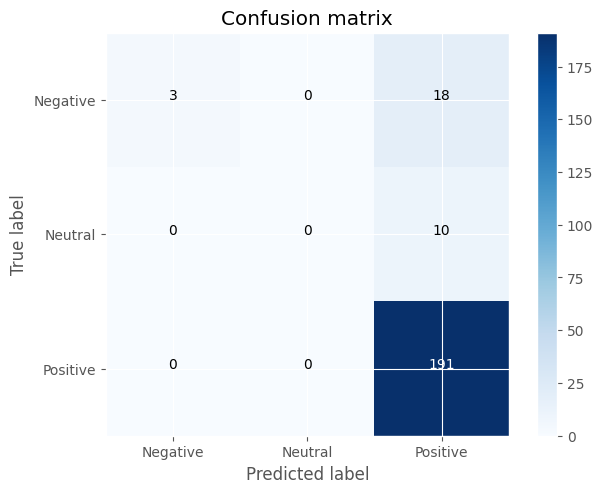

In [19]:
best_SVC = hypertuning(classifier = SV, 
                      param_grid = svc_params, 
                      metric='accuracy', 
                      verbose_value=1)

On the main diagonal we can see the correctly classified reviews. As expected from the analysis of the sentences, reviews, whether they are negative, neutral or positive, tend to be classified as positive. But I would say this is pretty much normal, even after the SMOTE balancing, since the reviews (with regard to their sentiment) are not that easy to classify.

#### Tuning XGBOOST

In [20]:
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
print(f'Base XGB accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base XGB F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base XGB accuracy on test set is: 0.8783783783783784
Base XGB F1 score on test set is: 0.85937212722927


In [21]:
# XGB.get_params()
# defining some of the hyperparameters
xgb_params = {
        'max_depth': [3,5,7,9],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],           # Subsample ratio of the training instances
        'colsample_bytree': [0.5, 0.8, 1.0],    # Subsample ratio of columns for constructing each tree
        'reg_alpha': [0, 0.01, 0.1],            # L1 regularization term on weights
        'reg_lambda': [0, 0.01, 0.1],           # L2 regularization term on weights
        'max_depth': [3, 4, 5],
        'num_class': [3],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [100, 200, 300]         # Number of boosting rounds
        }

In [22]:
# best_XGB = hypertuning(classifier = XGB, 
#                       param_grid = xgb_params, 
#                       metric='accuracy', 
#                       verbose_value=1)

Tuned XGB accuracy on test set is: 0.8783783783783784
Tuned XGB F1 score on test set is: 0.855978977806389


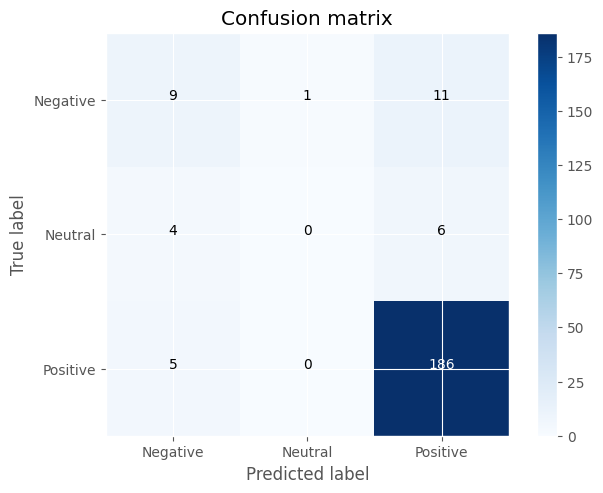

In [23]:
# saving the results to avoid fitting the randomized search again (since it took nearly 10 minutes)
best_XGB = xgb.XGBClassifier(colsample_bytree=0.5,
							gamma=2,
							learning_rate=0.1,
							max_depth=5,
							min_child_weight=5,
							n_estimators=100,
							reg_alpha=0.1,
							reg_lambda=0,
                            num_class=3,
							subsample=1.0)
best_XGB.fit(X_train, y_train)
y_pred = best_XGB.predict(X_test)
print(f'Tuned XGB accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Tuned XGB F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')
confusion = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(confusion, classes=['Negative','Neutral','Positive'])

Our LR is better than the XGBoost.

#### Tuning KNN

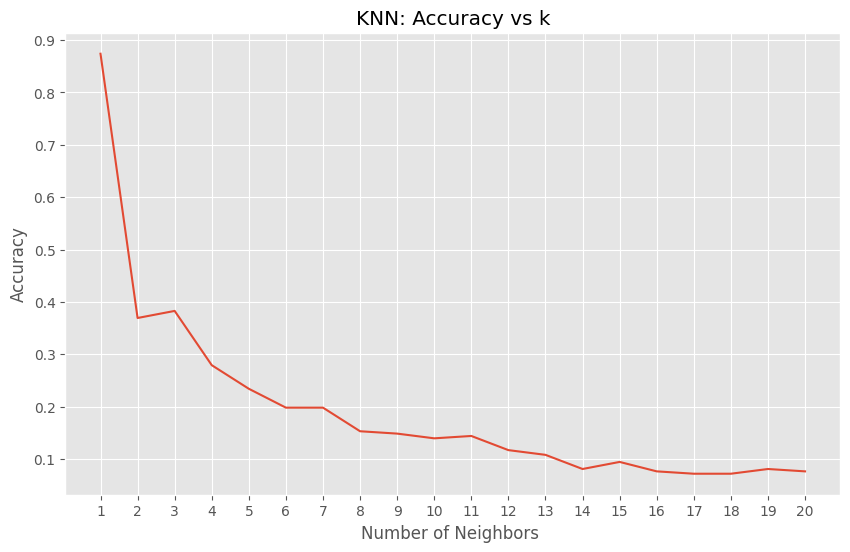

In [35]:
mean_acc = np.zeros(20)
for i in range(1,21):
    # train model with different k and predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat= knn.predict(X_test)
    mean_acc[i-1] = accuracy_score(y_test, yhat)
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.title('KNN: Accuracy vs k')
plt.show()

In [34]:
KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
print(f'Base KNN (k=1) accuracy on test set is: {accuracy_score(y_test, y_pred)}')
print(f'Base KNN (k=1) F1 score on test set is: {f1_score(y_test, y_pred, average="weighted")}')

Base KNN (k=1) accuracy on test set is: 0.8738738738738738
Base KNN (k=1) F1 score on test set is: 0.837407699476665


In [31]:
# define the hyperparameter space
knn_params = {'weights' : ['uniform','distance'],
              'metric' : ['minkowski','euclidean','manhattan']
}

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score: 0.9955719557195574
Hyperparameter set:
	metric: manhattan
	weights: uniform
Tuned LR accuracy on test set is: 0.8693693693693694
Tuned LR F1 score on test set is: 0.816104902109345


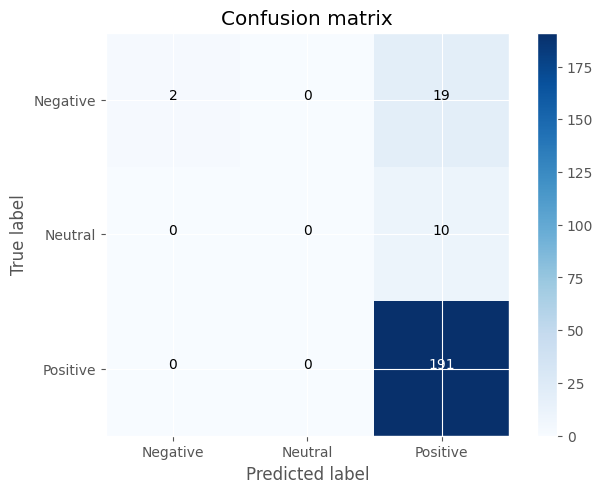

In [32]:
best_KNN = hypertuning(classifier = KNN, 
                      param_grid = knn_params, 
                      metric='accuracy', 
                      verbose_value=1)

The base KNN (k=1) seems like a really good model since it does not overfit the train data and then perform really well on validation data.

In [37]:
best_KNN = KNN

### Results

#### Validation and Test Sets

In [60]:
tuned_crossval_dict = {0: 'Logistic Regression',
                       1: 'SVC',
                       2: 'Random Forest',
                       3: 'XGBoost',
                       4: 'KNN',
                       5: 'MultinomialNB'}
tuned_crossval_models=[best_LR, best_SVC, best_RF, best_XGB, best_KNN, best_MNB]
crossval_models = [LR, SV, RF, XGB, KNN, MNB]

In [61]:
print('---------BASE MODELS RESULTS ON VALIDATION SET---------')
results = []
for i, model in enumerate(crossval_models):
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, model.predict(X_test), average="micro")
    f1 = f1_score(y_test, model.predict(X_test), average="weighted")
    results.append({'Model': tuned_crossval_dict[i], 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})
df_results = pd.DataFrame(results)
df_results

---------BASE MODELS RESULTS ON VALIDATION SET---------


,Model,Accuracy,Precision,F1
0,Logistic Regression,0.905405,0.905405,0.886672
1,SVC,0.873874,0.873874,0.825253
2,Random Forest,0.878378,0.878378,0.842828
3,XGBoost,0.878378,0.878378,0.859372
4,KNN,0.873874,0.873874,0.837408
5,MultinomialNB,0.828829,0.828829,0.845109


Overfitting occurs when the model learns the training data too well and fails to generalize to new, unseen data. But from these results it seems that the overfitted base models perform pretty good also on the validation set, which is strange but it could happen.

In [62]:
print('---------FINAL TUNED RESULTS ON VALIDATION SET---------')
results = []
for i, model in enumerate(tuned_crossval_models):
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, model.predict(X_test), average="micro")
    f1 = f1_score(y_test, model.predict(X_test), average="weighted")
    results.append({'Model': tuned_crossval_dict[i], 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})
df_results = pd.DataFrame(results)
df_results

---------FINAL TUNED RESULTS ON VALIDATION SET---------


,Model,Accuracy,Precision,F1
0,Logistic Regression,0.900901,0.900901,0.880616
1,SVC,0.873874,0.873874,0.825253
2,Random Forest,0.869369,0.869369,0.829098
3,XGBoost,0.878378,0.878378,0.855979
4,KNN,0.873874,0.873874,0.837408
5,MultinomialNB,0.882883,0.882883,0.874879


Knowing that we begun from a set of overfitted models, these results are good. However, it does not guarantee that the overfitting has been completely eliminated. The logistic regression is our preferred model: seems like that on unseen data our LR could classify the reviews with nearly 90% accuracy, which is good. The cross-validated tuned version takes into account the potential for overfitting, provides better generalization performance, and is less likely to be biased by a specific test set. Since we have a balanced train set the accuracy and the F1 are two really good indicators: in the case we had imbalanced data we might pay attention a lot more to precision and recall.

What could be interesting now is to scrape new reviews from the product and use those as a **real test set**: we used our dataset to train and validate the models but now the Logistic Regression (for example) is ready to be tested on new reviews.

To do this, since amazon blocks me if i scrape more than 74-75 pages on the interested pair of speakers, I exploit the class Reviews to scrape new data from another pair of speakers (which are basically the same as the ones analyzed until now) and use those reviews as test set. The reviews really similar but not refer to the same product which obviously will produce bias, therefore i expect lower results, nut not drastically. This is just to have an idea whether our models are good or not.

In [45]:
import sys
import time
sys.path.append(r'G:\Il mio Drive\MAGISTRALE\IT Coding\Project\Sentiment-Analysis-on-Amazon-product-reviews\Scripts')

from reviews import Reviews

In [46]:
%%capture output
%run "1. Load, Clean and Prepare Data.ipynb"

In [47]:
amz = Reviews('B09V1FYVTB')
results = []
# getting 
for i in range(1,20):              
    time.sleep(0.3)                 # to let the loop "breathe"
    reviews = amz.pagination(i)
    if reviews:                     # if there is something into reviews (seeing the many errors i've gotten) -> append it to the results
        results.append(amz.parse(reviews))
amz.save(results)

In [48]:
path = 'G:\Il mio Drive\MAGISTRALE\IT Coding\Project\Sentiment-Analysis-on-Amazon-product-reviews\Data\B09V1FYVTB_reviews.json'
df_test = json_2_pandas(json_path = path)
df_test.shape

(82, 4)

We got some new reviews to be used as a **real test set**: let's see how our logistic regression is able to classify the new unseen reviews.

In [49]:
# quick cleaning to have same formats as our train and validation sets used to train the models
df_test['Title'] = df_test['Title'].str.lower()
df_test['Content'] = df_test['Content'].str.lower()

df_test['Sentiment'] = df_test['Rating'].apply(rating_2_sentiment)

df_test['Review'] = df_test['Title'] + '. ' + df_test['Content']
df_test['Clean Review'] = df_test['Title'] + '. ' + df_test['Content']
df_test['Clean Review'] = df_test['Clean Review'].apply(data_cleaning)
df_test['Clean Review'] = df_test['Clean Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_test['Clean Review'] = df_test['Clean Review'].apply(lemmatize)

df_test['Target'] = encoder.fit_transform(df_test['Sentiment'])
y_val = df_test['Target']

X_val = tfidf.transform(df_test['Clean Review']).toarray()

In [63]:
print('---------FINAL TUNED RESULTS ON TEST SET---------')
results = []
for i, model in enumerate(tuned_crossval_models):
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average="micro")
    f1 = f1_score(y_val, y_val_pred, average="weighted")
    results.append({'Model': tuned_crossval_dict[i], 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})
df_results = pd.DataFrame(results)
df_results

---------FINAL TUNED RESULTS ON TEST SET---------


,Model,Accuracy,Precision,F1
0,Logistic Regression,0.817073,0.817073,0.734817
1,SVC,0.817073,0.817073,0.734817
2,Random Forest,0.817073,0.817073,0.734817
3,XGBoost,0.817073,0.817073,0.734817
4,KNN,0.817073,0.817073,0.734817
5,MultinomialNB,0.804878,0.804878,0.747043


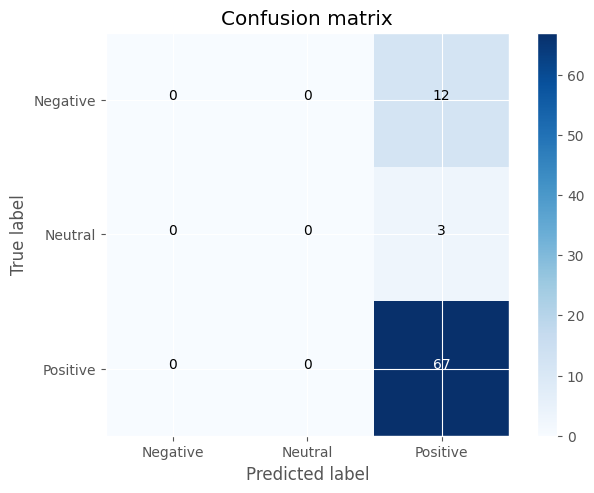

In [51]:
# since all results are nearly all the same i plot a single confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
confusion_matrix_plot(confusion, classes=['Negative','Neutral','Positive'])

I also tried the whole analysis with and without stopwords: there are no big changes (only a general 1% decrease in accuracy and F1 which is not considerable).

#### ROC-AUC curve

The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve(Receiver Operating Curve). These 2 tools (AUC and ROC) provide insights into the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at different classification thresholds. 

Here I plotted the ROC for Logistic Regression and Multinomial NB Classifier (the 2 best fine-tuned models) for the 3 different sentiments and through that we can understand which class was classified better. Also we plot micro and macro averages on the roc curve. Since this a multiclass and not a binary classification problem, I used the OneVsRestClassifier to plot one line for each class. The roc_curve function simply calculates the 2 rates and the thresholds associated to to each pair of rates.

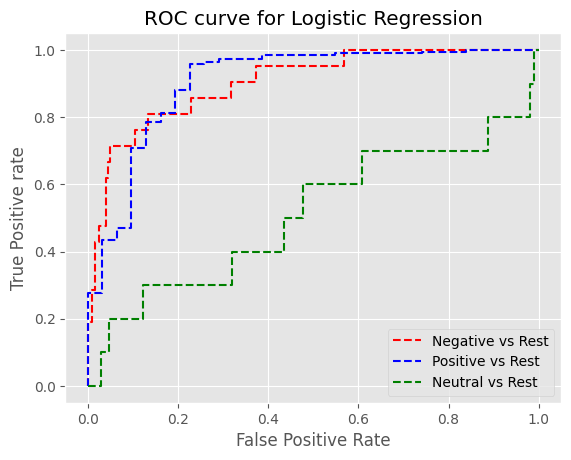

In [ ]:
# fit model
clf = OneVsRestClassifier(best_LR)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Negative vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Positive vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Neutral vs Rest')
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

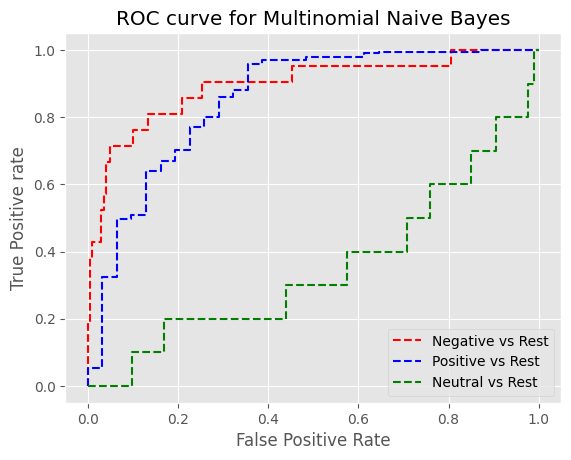

In [70]:
clf = OneVsRestClassifier(best_MNB)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Negative vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Positive vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Neutral vs Rest')
plt.title('ROC curve for Multinomial Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

We notice an important thing: negative reviews are classified well (same for the positive ones but that was expected) since their area under the curve is high:we can chose any threshold between 0.6-0.8 to get the optimal number of TPR (True Positive Rate) and FPR (False Positive Rate). Neutral reviews have a lower "accuracy" when it comes to classifing them (they are difficult to classify).

## RoBERTa

### The Transformers Pipeline

In [ ]:
# from transformers import pipeline

# sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline = ('phrase')